# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [110]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import statistics as stats
import itertools
from sklearn.metrics import accuracy_score

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [111]:
# Define transforms
transform_train = transforms.Compose(
    [transforms.RandomRotation(10),
     transforms.RandomHorizontalFlip(),
     transforms.RandomInvert(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create training set and define training dataloader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                            shuffle=True, num_workers=2)

# Create test set and define test dataloader
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                            shuffle=False, num_workers=2)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [112]:
# Show shape of the training data
print("Shape of the training data:", trainset.data.shape)

# Show shape of the test data
print("Shape of the test data:", testset.data.shape)

Shape of the training data:  (50000, 32, 32, 3)
Shape of the test data:  (10000, 32, 32, 3)


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

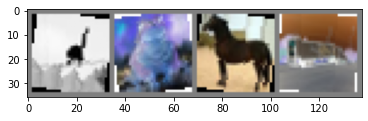

In [113]:
# Explore data
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Define a function to show images in a batch
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Show some imgaes
imshow(torchvision.utils.make_grid(images))

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [114]:
# Define the model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        # Softmax output
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

# Instantiate the model
model = Model()

# # Visualize the model using pytorch_model_summary
# from pytorch_model_summary import summary
# print(summary(model, torch.zeros((1, 3, 32, 32)), show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 3, 32, 32]             896             896
       MaxPool2d-2     [1, 32, 32, 32]               0               0
          Conv2d-3     [1, 32, 16, 16]          18,496          18,496
       MaxPool2d-4     [1, 64, 16, 16]               0               0
          Conv2d-5       [1, 64, 8, 8]          73,856          73,856
       MaxPool2d-6      [1, 128, 8, 8]               0               0
         Dropout-7           [1, 2048]               0               0
          Linear-8           [1, 2048]       1,024,500       1,024,500
         Dropout-9            [1, 500]               0               0
         Linear-10            [1, 500]           5,010           5,010
Total params: 1,122,758
Trainable params: 1,122,758
Non-trainable params: 0
-----------------------------------------------------------------------

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [115]:
# Define the loss function; choosing cross entropy loss
criterion = nn.CrossEntropyLoss()

# Define momentum and learning rate for the optimizer
momentum = 0.93
learning_rate = 0.0003

# Define the optimizer; choosing SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [116]:
# Ensure the model is trained on the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train the model
epochs = 25
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

start_time = time.time()

for epoch in range(epochs):
    train_loss = 0.0
    train_accuracy = 0.0
    test_loss = 0.0
    test_accuracy = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Set the parameter gradients zero
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Gather statistics
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_accuracy += (predicted == labels).sum().item()
    train_loss /= len(trainloader)
    train_accuracy /= len(trainset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
stop_time = time.time()
print("Train time: {}".format(stop_time - start_time))
print("Train loss: {}".format(train_loss))
print("Train accuracy: {}".format(train_accuracy * 100))

Train time: 24471.59418106079
Train loss: 0.20908795533500213
Train accuracy: 92.994


Plot the training loss (and validation loss/accuracy, if recorded).

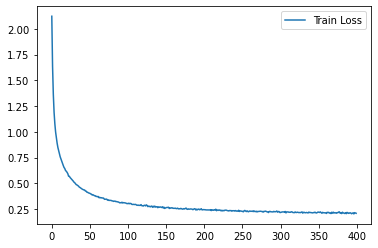

In [117]:
# Show training loss
plt.plot(train_losses, label="Train Loss")
plt.legend()
plt.show()

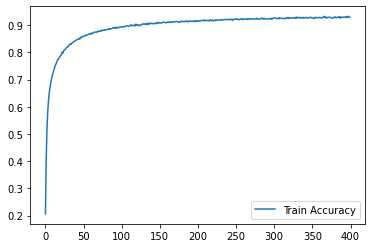

In [118]:
# Show training accuracy
plt.plot(train_accuracies, label="Train Accuracy")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [119]:
# Test the model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 78 %


## Saving your model
Using `torch.save`, save your model for future loading.

In [120]:
# Save the model
torch.save(model.state_dict(), "model_25epochs.pt")

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

**This model surpasses Detectocorp’s algorithm accuracy by 5%, despite being trained for only 25 epochs. If trained for more, its accuracy can surely be improved. Moreover, doing granular hyperparameter optimization will also help improve the model. Therefore, my recommendation is to build an in-house solution based on this model, instead of purchasing the algorithm from Detectocorp.**